In [1]:
from util import *
from eval import *
from data import FacesDataset, data_transform
import time
# from ..utils.data import FacesDataset, data_transform
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt

/home/abhigyan/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [86]:
class RequestDetails(object):
	"""docstring for RequestDetails"""
	def __init__(self, accuracy, latency, tasks, input_image):
		self.accuracy = accuracy
		self.latency = int(latency)
		self.tasks = tasks
		self.input_image = input_image
		

def process_request(request_details):
	model_to_use = None
	# print(three_task_table)
	task_count = len(request_details.tasks)
	if(task_count > 1):
		for latency in three_task_table["age"]:
			if(latency <= request_details.latency):
				if(model_to_use == None):
					model_to_use = three_task_table["age"][latency]
				else:	
					mean_acc = (float(three_task_table["age"][latency].accuracy[0]) + float(three_task_table["gender"][latency].accuracy[1]) + float(three_task_table["ethnicity"][latency].accuracy[2])) / 3.0
					mean_acc_existing = (float(model_to_use.accuracy[0]) + float(model_to_use.accuracy[1]) + float(model_to_use.accuracy[2]))/3.0 
					if(mean_acc_existing < mean_acc): model_to_use = three_task_table["age"][latency] 
	else:
		if(request_details.tasks[0] == "age"):
			for latency in age_task_table["age"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = age_task_table["age"][latency]
					else:
						if(model_to_use.accuracy[0] < float(age_task_table["age"][latency].accuracy[0])):
							model_to_use = age_task_table["age"][latency]
		elif(request_details.tasks[0] == "gender"):
			for latency in gender_task_table["gender"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = gender_task_table["gender"][latency]	
					else:
						if(model_to_use.accuracy[0] < float(gender_task_table["gender"][latency].accuracy[0])):
							model_to_use = gender_task_table["gender"][latency]
		elif(request_details.tasks[0] == "ethnicity"):	
			for latency in ethnicity_task_table["ethnicity"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = ethnicity_task_table["ethnicity"][latency]	
					else:
						if(model_to_use.accuracy[0] < float(ethnicity_task_table["ethnicity"][latency].accuracy[0])):
							model_to_use = ethnicity_task_table["ethnicity"][latency]

	if(model_to_use == None):
		## Cannot meet latency requirement with any model
		return None, None
	else:
		model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
		model.cpu()
		output = model(request_details.input_image)
		# return output, model_to_use.latency
		if(task_count > 1):
			return output, (float(model_to_use.accuracy[0]) + float(model_to_use.accuracy[1]) + float(model_to_use.accuracy[2]))/3.0
		else:
			return output, model_to_use.accuracy[0]

def process_request_with_accuracy(request_details):
	model_to_use = None
	task_count = len(request_details.tasks)
	if(task_count > 1):
		for latency in three_task_table["age"]:
			# print(float(three_task_table["gender"][latency].accuracy[1]), request_details.accuracy[1])
			mean_acc = float(three_task_table["age"][latency].accuracy[0]) >= request_details.accuracy[0] and\
				float(three_task_table["gender"][latency].accuracy[1]) >= request_details.accuracy[1] and\
				float(three_task_table["ethnicity"][latency].accuracy[2]) >= request_details.accuracy[2]
			if(latency <= request_details.latency and mean_acc == True):
					model_to_use = three_task_table["age"][latency]
	else:
		if(request_details.tasks[0] == "age"):
			for latency in age_task_table["age"]:
				if(latency <= request_details.latency and float(age_task_table["age"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = age_task_table["age"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(age_task_table["age"][latency].accuracy[0])):
							model_to_use = age_task_table["age"][latency]
		elif(request_details.tasks[0] == "gender"):
			for latency in gender_task_table["gender"]:
				if(latency <= request_details.latency and float(gender_task_table["gender"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = gender_task_table["gender"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(gender_task_table["gender"][latency].accuracy[0])):
							model_to_use = gender_task_table["gender"][latency]
		elif(request_details.tasks[0] == "ethnicity"):	
			for latency in ethnicity_task_table["ethnicity"]:
				if(latency <= request_details.latency and float(ethnicity_task_table["ethnicity"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = ethnicity_task_table["ethnicity"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(ethnicity_task_table["ethnicity"][latency].accuracy[0])):
							model_to_use = ethnicity_task_table["ethnicity"][latency]

	if(model_to_use == None):
		## Cannot meet latency/accuracy requirement with any model
		return None, None
	else:
		# print("asd", request_details.tasks)
		# print(model_to_use.latency, end=" ")
		model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
		model.cpu()
		output = model(request_details.input_image)
		return output, model_to_use.accuracy[0]
		# return output, model_to_use.latency

def process_request_only_mtl(request_details, with_accuracy=False):
	if(request_details.tasks[0] == "age"):
		model_to_use = None
		for latency in three_task_table["age"]:
			if(latency <= request_details.latency):
				if(with_accuracy):
					if( float(three_task_table["age"][latency].accuracy[0]) < request_details.accuracy): continue
				if(model_to_use == None):
					model_to_use = three_task_table["age"][latency]
				else:
					if(float(model_to_use.accuracy[0]) < float(three_task_table["age"][latency].accuracy[0])):
						model_to_use = three_task_table["age"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			return output, model_to_use.accuracy[0]
	elif(request_details.tasks[0] == "gender"):
		model_to_use = None
		for latency in three_task_table["gender"]:
			if(latency <= request_details.latency):
				if(with_accuracy):
					if( float(three_task_table["gender"][latency].accuracy[1]) < request_details.accuracy): continue
				if(model_to_use == None):
					model_to_use = three_task_table["gender"][latency]	
				else:
					if(float(model_to_use.accuracy[0]) < float(three_task_table["gender"][latency].accuracy[1])):
						model_to_use = three_task_table["gender"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			return output, model_to_use.accuracy[1]

	elif(request_details.tasks[0] == "ethnicity"):	
		model_to_use = None
		for latency in three_task_table["ethnicity"]:
			if(latency <= request_details.latency):
				if(with_accuracy):
					if( float(three_task_table["ethnicity"][latency].accuracy[2]) < request_details.accuracy): continue
				if(model_to_use == None):
					model_to_use = three_task_table["ethnicity"][latency]	
				else:
					if(float(model_to_use.accuracy[0]) < float(three_task_table["ethnicity"][latency].accuracy[2])):
						model_to_use = three_task_table["ethnicity"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			return output, model_to_use.accuracy[2]


def process_request_single_model_system(request_details, with_accuracy=False):
	# print(three_task_table)
	task_count = len(request_details.tasks)
	if( len(request_details.tasks) > 1): req_latency = request_details.latency/3.0
	else: req_latency = request_details.latency 
	perf = []
	output = None
	if(len(request_details.tasks) > 1 or request_details.tasks[0] == "age"):
		model_to_use = None
		for latency in single_age_task_table["age"]:
			if(latency <= req_latency):
				if(with_accuracy):
					if(len(request_details.tasks) > 1): acc = request_details.accuracy[0]
					else: acc = request_details.accuracy
					if( float(single_age_task_table["age"][latency].accuracy[0]) < acc): continue
				if(model_to_use == None):
					model_to_use = single_age_task_table["age"][latency]
				else:
					if(model_to_use.accuracy[0] < float(single_age_task_table["age"][latency].accuracy[0])):
						model_to_use = single_age_task_table["age"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			perf.append(model_to_use.accuracy[0])
	if(len(request_details.tasks) > 1 or request_details.tasks[0] == "gender"):
		model_to_use = None
		for latency in single_gender_task_table["gender"]:
			if(latency <= req_latency):
				if(with_accuracy):
					if(len(request_details.tasks) > 1): acc = request_details.accuracy[1]
					else: acc = request_details.accuracy
					if( float(single_gender_task_table["gender"][latency].accuracy[0]) < acc): continue
				if(model_to_use == None):
					model_to_use = single_gender_task_table["gender"][latency]	
				else:
					if(model_to_use.accuracy[0] < float(single_gender_task_table["gender"][latency].accuracy[0])):
						model_to_use = single_gender_task_table["gender"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			perf.append(model_to_use.accuracy[0])
	if(len(request_details.tasks) > 1 or request_details.tasks[0] == "ethnicity"):	
		model_to_use = None
		for latency in single_ethnicity_task_table["ethnicity"]:
			if(latency <= req_latency):
				if(with_accuracy):
					if(len(request_details.tasks) > 1): acc = request_details.accuracy[2]
					else: acc = request_details.accuracy
					if( float(single_ethnicity_task_table["ethnicity"][latency].accuracy[0]) < acc): continue
				if(model_to_use == None):
					model_to_use = single_ethnicity_task_table["ethnicity"][latency]	
				else:
					if(model_to_use.accuracy[0] < float(single_ethnicity_task_table["ethnicity"][latency].accuracy[0])):
						model_to_use = single_ethnicity_task_table["ethnicity"][latency]
		if(model_to_use == None):
			return None, None
		else:
			model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
			model.cpu()
			output = model(request_details.input_image)
			perf.append(model_to_use.accuracy[0])

	return output, np.mean(perf)

def process_batch_requests(requests, min_accuracy=False, mtl_model=True, only_mtl=False):

	## Can write some queing stuff
	## iterate on the requests and call process_request
	latency_hit = []
	accuracy_hit = []
	lat_acc_pair = []
	for request in requests:
		if(min_accuracy):
			start_time = time.time()
			if(only_mtl):
				output, accuracy = process_request_only_mtl(request, with_accuracy=True)
			elif(mtl_model):
				output, accuracy = process_request_with_accuracy(request)
			else:                
				output, accuracy = process_request_single_model_system(request, with_accuracy=True)
			end_time = time.time()
			inf_time = (end_time-start_time)*1000
			# print(inf_time, request.latency, accuracy)
			# print(inf_time, start_time, end_time)
			# print(inf_time)
			if(inf_time <= request.latency + 5 and output!=None):
				latency_hit.append(1)
			else:
				latency_hit.append(0)

			if(accuracy!=None ):
				accuracy_hit.append(1)
			else:
				accuracy_hit.append(0)
			
		else:
			start_time = time.time()
			if(only_mtl):
				output, accuracy = process_request_only_mtl(request)
			elif(mtl_model):
				output, accuracy = process_request(request)
			else:
				output, accuracy = process_request_single_model_system(request)
			end_time = time.time()
			inf_time = (end_time-start_time)*1000
			# print(inf_time, request.latency, accuracy)
			# print(inf_time, end_time, output)
			if(inf_time <= request.latency and output!=None):
				latency_hit.append(1)
			else:
				latency_hit.append(0)
			if (accuracy != None):
				lat_acc_pair.append([request.latency, accuracy])
	return latency_hit, accuracy_hit, lat_acc_pair


In [3]:
def plot_double_pareto_curve_graph(pair1, pair2):
	fig, ax = plt.subplots(1, figsize=(8, 6))
	fig.suptitle('All three tasks', fontsize=15)

	x1, y1 = [], []
	x2, y2 = [], []
	for i in pair1:
		x1.append(i[0])
		y1.append(float(i[1]))
	for i in pair2:
		x2.append(i[0])
		y2.append(float(i[1]))

	ax.plot(x1, y1, color="red", label="MTL Model")
	ax.plot(x2, y2, color="green", label="Single Task Models")
	plt.xlabel("Latency")
	plt.ylabel("Performance Scores")
	plt.legend(loc="lower right", frameon=False)

	plt.show()
    

In [30]:
def plot_triple_pareto_curve_graph(pair1, pair2, pair3, title):
	fig, ax = plt.subplots(1, figsize=(8, 6))
	fig.suptitle(title, fontsize=15)

	x1, y1 = [], []
	x2, y2 = [], []
	x3, y3 = [], []
	for i in pair1:
		x1.append(i[0])
		y1.append(float(i[1]))
	for i in pair2:
		x2.append(i[0])
		y2.append(float(i[1]))
	for i in pair3:
		x3.append(i[0])
		y3.append(float(i[1]))

	ax.plot(x1, y1, color="red", label="MTL Model with Prune Single Task Heads")
	ax.plot(x2, y2, color="green", label="Single Task Models")
	ax.plot(x3, y3, color="blue", label="Traditional MTL Model")
	plt.xlabel("Latency")
	plt.ylabel("Performance Scores")
	plt.legend(loc="lower right", frameon=False)

	plt.show()
    

In [5]:
### Load in the data
folder = '../UTKFace'
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))


dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)


In [6]:
print("Loading all task models..")
### All three tasks
three_task_models = load_all_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants")
three_task_table = get_models_table(three_task_models)

print("Loading single age models..")
### Age
single_age_task_models = load_one_task_models_info(dataloader, "model_score_lookup_singletask.tsv", "../models/model_variants", "age", False)
single_age_task_table = get_models_table(single_age_task_models)
print("Loading single gender models..")
### Gender
single_gender_task_models = load_one_task_models_info(dataloader, "model_score_lookup_singletask.tsv", "../models/model_variants", "gender", False)
single_gender_task_table = get_models_table(single_gender_task_models)

print("Loading single ethnicity models..")
### Ethnicity
single_ethnicity_task_models = load_one_task_models_info(dataloader, "model_score_lookup_singletask.tsv", "../models/model_variants/", "ethnicity", False)
single_ethnicity_task_table = get_models_table(single_ethnicity_task_models)

min_latency = int(min(three_task_table["age"]))
max_latency = int(max(three_task_table["age"])) + 10



Loading all task models..
Loading single age models..
Loading single gender models..
Loading single ethnicity models..


In [8]:

print("Loading age models..")
### Age
age_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants", "age", True)
age_task_table = get_models_table(age_task_models)
print("Loading gender models..")
### Gender
gender_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants", "gender", True)
gender_task_table = get_models_table(gender_task_models)

print("Loading ethnicity models..")
### Ethnicity
ethnicity_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants/", "ethnicity", True)
ethnicity_task_table = get_models_table(ethnicity_task_models)

Loading age models..
Loading gender models..
Loading ethnicity models..


In [ ]:
## All Tasks 

batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
lat_acc = []
for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
		requests = []
		hits+=lat_hit
		lat_acc+=lat_acc_pair
	request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
hits+=lat_hit
lat_acc+=lat_acc_pair

# SLO_hit = calculate_SLO_hit(hits)

# print("All Task MTL System (No Accuracy) SLO hit/mishit ratio: " + str(SLO_hit) + ", hits: " + str(sum(hits)) + ", mishits: " + str(len(hits) - sum(hits)))
# print()


batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
lat_acc1 = []
for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, False, False)
		requests = []
		hits+=lat_hit
		lat_acc1+=lat_acc_pair
	request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
hits+=lat_hit
lat_acc1+=lat_acc_pair



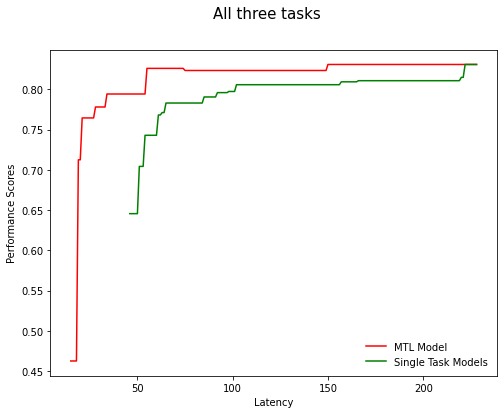

In [35]:
plot_double_pareto_curve_graph(lat_acc, lat_acc1)

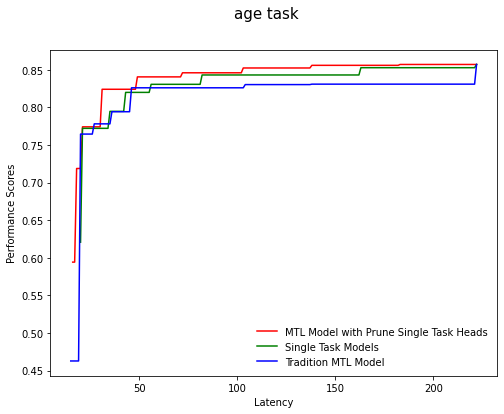

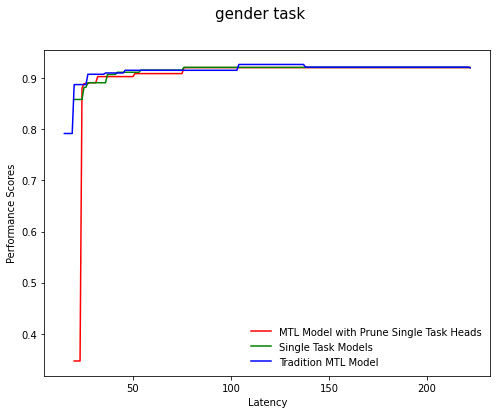

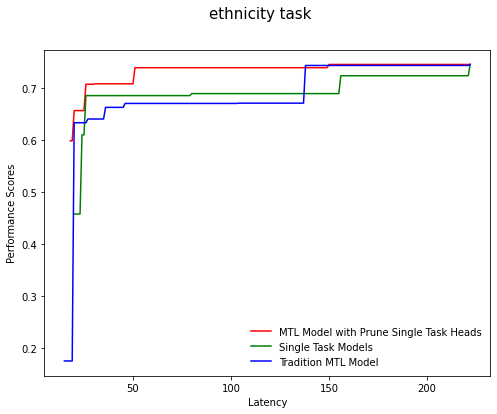

In [29]:
## Age Task

tasks_list = [["age"], ["gender"],["ethnicity"]]

for tasks in tasks_list:
    batch_size = 8 # No relevance now since we are not doing queueing
    # tasks = ["age"]
    requests = []
    hits = []
    lat_acc_age = []
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
            requests = []
            hits+=lat_hit
            lat_acc_age+=lat_acc_pair
        request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests)
    hits+=lat_hit
    lat_acc_age+=lat_acc_pair

    # SLO_hit = calculate_SLO_hit(hits)

    # print("All Task MTL System (No Accuracy) SLO hit/mishit ratio: " + str(SLO_hit) + ", hits: " + str(sum(hits)) + ", mishits: " + str(len(hits) - sum(hits)))
    # print()


    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    # tasks = ["age"]
    hits = []
    lat_acc_age1 = []
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, mtl_model=False)
            requests = []
            hits+=lat_hit
            lat_acc_age1+=lat_acc_pair
        request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, mtl_model=False)
    hits+=lat_hit
    lat_acc_age1+=lat_acc_pair

    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    # tasks = ["age"]
    hits = []
    lat_acc_age2 = []
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, only_mtl=True)
            requests = []
            hits+=lat_hit
            lat_acc_age2+=lat_acc_pair
        request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, only_mtl=True)
    hits+=lat_hit
    lat_acc_age2+=lat_acc_pair
    plot_triple_pareto_curve_graph(lat_acc_age, lat_acc_age1, lat_acc_age2, tasks[0] + " task")

In [78]:
#Mis-hit calculations with Accuracy cutoff 

batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
acc_hits = []
accuracy = [0.75, 0.90, 0.60] 

for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair= process_batch_requests(requests, min_accuracy=True)
		requests = []
		hits+=lat_hit
		acc_hits+=acc_hit

	request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True)
hits+=lat_hit
acc_hits+=acc_hit

actual_hits = []
for i in range(len(hits)):
    if(hits[i] == 1 and acc_hits[i] ==1):
        actual_hits.append(1)
    else:
        actual_hits.append(0)
        

print("All Task MTL System (Accuracy>75%) SLO mishit rate: " + str((len(hits) - sum(hits))/ len(hits)) + ", hits: " + str(sum(hits)) + ", mishits: " + str(len(hits) - sum(hits)))


batch_size = 8 # No relevance now since we are not doing queueing
requests = []
tasks = ["age", "gender", "ethnicity"]
hits = []
acc_hits = []
accuracy = [0.75, 0.90, 0.60]
for i in range(min_latency, max_latency):
	if(len(requests) == batch_size):	
		lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
		requests = []
		hits+=lat_hit
		acc_hits+=acc_hit
	request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
	requests.append(request)

lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
hits+=lat_hit
acc_hits+=acc_hit

actual_hits = []
for i in range(len(hits)):
    if(hits[i] == 1 and acc_hits[i] ==1):
        actual_hits.append(1)
    else:
        actual_hits.append(0)
        

print("All Task Single Model System (Accuracy>75%) SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))



KeyboardInterrupt: 

In [90]:
#Mis-hit calculations with Accuracy cutoff - 0.75


## Single Tasks 
tasks_list = [["age"], ["gender"],["ethnicity"]]
accuracy_list = [0.75, 0.90, 0.60] 
idx = -1
for tasks in tasks_list:
    idx+=1
    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    hits = []
    acc_hits = []
    accuracy = accuracy_list[idx]
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair= process_batch_requests(requests, min_accuracy=True)
            requests = []
            hits+=lat_hit
            acc_hits+=acc_hit

        request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True)
    hits+=lat_hit
    acc_hits+=acc_hit

    actual_hits = []
    for i in range(len(hits)):
        if(hits[i] == 1 and acc_hits[i] ==1):
            actual_hits.append(1)
        else:
            actual_hits.append(0)

    print(tasks[0] + " MTL System with Accuracy cutoff SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(actual_hits)))


    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    hits = []
    acc_hits = []
    accuracy = accuracy_list[idx]
    
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
            requests = []
            hits+=lat_hit
            acc_hits+=acc_hit
        request = RequestDetails(accuracy, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, mtl_model=False)
    hits+=lat_hit
    acc_hits+=acc_hit

    actual_hits = []
    for i in range(len(hits)):
        if(hits[i] == 1 and acc_hits[i] ==1):
            actual_hits.append(1)
        else:
            actual_hits.append(0)


    print(tasks[0] + " Single Model System with Accuracy Cutoff SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(hits) - sum(actual_hits)))


    
    
    batch_size = 8 # No relevance now since we are not doing queueing
    requests = []
    hits = []
    acc_hits = []
    accuracy = accuracy_list[idx]
    for i in range(min_latency, max_latency):
        if(len(requests) == batch_size):	
            lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, only_mtl=True)
            requests = []
            hits+=lat_hit
            acc_hits+=acc_hit
            request = RequestDetails(0, i, tasks, next(iter(dataloader))[0])
        requests.append(request)

    lat_hit, acc_hit, lat_acc_pair = process_batch_requests(requests, min_accuracy=True, only_mtl=True)
    hits+=lat_hit
    acc_hits+=acc_hit
    actual_hits = []
    for i in range(len(hits)):
        if(hits[i] == 1 and acc_hits[i] ==1):
            actual_hits.append(1)
        else:
            actual_hits.append(0)


    print(tasks[0] + " Traditional MTL System with Accuracy Cutoff SLO mishit rate: " + str((len(actual_hits) - sum(actual_hits))/ len(actual_hits)) + ", hits: " + str(sum(actual_hits)) + ", mishits: " + str(len(actual_hits) - sum(hits)))


14 223
15 223
16 223
17 223
18 223
19 223
20 223
21 223
22 223
23 223
24 223
25 223
26 223
27 223
28 223
29 223
30 223
31 223
32 223
33 223
34 223
35 223
36 223
37 223
38 223
39 223
40 223
41 223
42 223
43 223
44 223
45 223
46 223
47 223
48 223
49 223
50 223
51 223
52 223
53 223
54 223
55 223
56 223
57 223
58 223
59 223
60 223
61 223
62 223
63 223
64 223
65 223
66 223
67 223
68 223
69 223
70 223
71 223
72 223
73 223
74 223
75 223
76 223
77 223
78 223
79 223
80 223
81 223
82 223
83 223
84 223
85 223
86 223
87 223
88 223
89 223
90 223
91 223
92 223
93 223
94 223
95 223
96 223
97 223
98 223
99 223
100 223
101 223
102 223
103 223
104 223
105 223
106 223
107 223
108 223
109 223
110 223
111 223
112 223
113 223
114 223
115 223
116 223
117 223
118 223
119 223
120 223
121 223
122 223
123 223
124 223
125 223
126 223
127 223
128 223
129 223
130 223
131 223
132 223
133 223
134 223
135 223
136 223
137 223
138 223
139 223
140 223
141 223
142 223
143 223
144 223
145 223
146 223
147 223
148 223
149 22